Imports and Torch version

In [106]:
# IMPORTS
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as tfs
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import os


print(torch.__version__)

2.1.0+cu118


Downloading MNIST Dataset

In [107]:
train_set = MNIST(
    root='./',
    train=True,
    download=True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
)

test_set = MNIST(
    root='./',
    train=False,
    download=True,
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

)

Data Loaders and Training/Validation split

In [108]:
num_workers = 0
batch_size = 128
valid_size = 0.2

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index , valid_index = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         num_workers=num_workers)

Function Gets the number of true positives by comparing the predictions and labels

In [109]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


Function to delete all files in a directory

In [110]:
def clear_directory(directory_path):
    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)):
            os.remove(os.path.join(directory_path, filename))

In [111]:
def check_file_exists(file_path):
    count = 0
    for path in os.listdir(file_path):
        if os.path.isfile(os.path.join(file_path, path)):
            count += 1
    return count

MLP Model

In [112]:
class MLP(nn.Module):
    # Inilize variables
    def __init__(self):
        super(MLP, self).__init__()
        self.Input = nn.Linear(in_features=784,out_features=512)
        self.Dropout1 = nn.Dropout(0.2)
        self.Hidden = nn.Linear(in_features=512,out_features=512)
        self.Dropout2 = nn.Dropout(0.2)
        self.Predictions = nn.Linear(in_features=512,out_features=10)
    # forward is used to describe the behavior of the model during a feed forward pass
    def forward(self, input_tensor):
        #Flatten the w and h of the image (2D --> 1D)
        x = torch.flatten(input_tensor,start_dim=1)
        x = self.Input(x)
        #Apply non linear activation function relu
        x = F.relu(x)
        x = self.Dropout1(x)
        x = self.Hidden(x)
        x = F.relu(x)
        x = self.Dropout2(x)
        x = self.Predictions(x)
        #Apply Softmax to the output of the model then return the result
        x = F.log_softmax(x, dim=1)
        return x
    # __repr__ returns the models architecture when called
    def __repr__(self):
        return super().__repr__()

Training Model Function

In [113]:
def train_model(model,optimizer,writer,n_epochs=20):
    for epoch in range(n_epochs):
        train_loss = 0
        val_loss = 0
        train_correct = 0
        val_correct = 0
        #Changing model state to train 
        model.train()
        for batch in train_loader: 
            images, labels = batch
            #Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            preds = model(images) # Pass or forward batch
            loss = F.cross_entropy(preds, labels) # Calculate loss using cross entropy multiclass
            loss.backward() # Calculate Gradients
            optimizer.step() # Update Weights
            #Add batch loss value to train loss (We want the mean)
            train_loss += loss.item() * images.size(0)
            #Add batch TP (True Positive) value to train correct (We want the mean Accuracy)
            train_correct += get_num_correct(preds, labels) 
        model.eval()
        for batch in valid_loader:
            images, labels = batch
            preds = model(images)
            loss = F.cross_entropy(preds, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += get_num_correct(preds, labels) 
        #Calculating the epochs values for loss acc val_loss and val_accuracy
        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(valid_loader.sampler)
        accuracy = train_correct / len(train_loader.sampler)
        val_accuracy = val_correct / len(valid_loader.sampler)
        #Adding these scalars to tensorboard usinf add_scalar function
        writer.add_scalar('Loss/loss', train_loss, epoch+1)
        writer.add_scalar('Loss/val_loss', val_loss, epoch+1)
        writer.add_scalar('Accuracy/acc', accuracy, epoch+1)
        writer.add_scalar('Accuracy/val_acc', val_accuracy, epoch+1)
        #Shawing the epochs scalar values
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch+1, 
            train_loss,
            val_loss,
            accuracy,
            val_accuracy
            ))
    writer.close()

Confusion Matrix function

In [114]:
def confusion_matrix_eval(model):
    y_pred = []
    y_tr = []
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval() # This prepares the model for evaluation
    for batch in test_loader:
        images, labels = batch
        preds = model(images)
        y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
        y_tr.extend(labels.detach().numpy().tolist())
        loss = F.cross_entropy(preds,labels) # Calculate loss
        test_loss += loss.item() * images.size(0) # update test loss
        _, pred = torch.max(preds, 1) # Convert output probabilities to predicted class
        correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare predictions to true label
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
    lbls = test_set.classes
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
    fig,ax = plt.subplots(figsize=(30,30))
    cmp.plot(cmap=plt.cm.Blues,ax=ax)
    plt.show()
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))

Training the MLP model

In [115]:
model = MLP()
path = '/mnt/d/VSCode/TD_Systèmes_Intelligents_Avancés/Results/MLP/'
if(check_file_exists(path)):
    clear_directory(path)
optimizer = optim.RMSprop(model.parameters(),lr=0.01)
writer = SummaryWriter(log_dir=path) #Initializing Tensorboard to store logs in the specified directory
train_model(model,optimizer,writer,20)

Epoch: 1 	Training Loss: 20.573546 	Validation Loss: 0.695930 	Accuracy: 0.629313 	Validation Accuracy: 0.798833
Epoch: 2 	Training Loss: 0.808820 	Validation Loss: 0.533069 	Accuracy: 0.758208 	Validation Accuracy: 0.842000
Epoch: 3 	Training Loss: 0.740653 	Validation Loss: 0.414676 	Accuracy: 0.782854 	Validation Accuracy: 0.885250
Epoch: 4 	Training Loss: 0.656501 	Validation Loss: 0.410005 	Accuracy: 0.810021 	Validation Accuracy: 0.881500
Epoch: 5 	Training Loss: 0.633812 	Validation Loss: 0.366213 	Accuracy: 0.820688 	Validation Accuracy: 0.898250
Epoch: 6 	Training Loss: 0.602357 	Validation Loss: 0.348412 	Accuracy: 0.830729 	Validation Accuracy: 0.905167
Epoch: 7 	Training Loss: 0.582335 	Validation Loss: 0.563130 	Accuracy: 0.838313 	Validation Accuracy: 0.808000
Epoch: 8 	Training Loss: 0.551064 	Validation Loss: 0.309313 	Accuracy: 0.848313 	Validation Accuracy: 0.917833
Epoch: 9 	Training Loss: 0.528173 	Validation Loss: 0.413993 	Accuracy: 0.853854 	Validation Accuracy: 

Matrice de Confusion

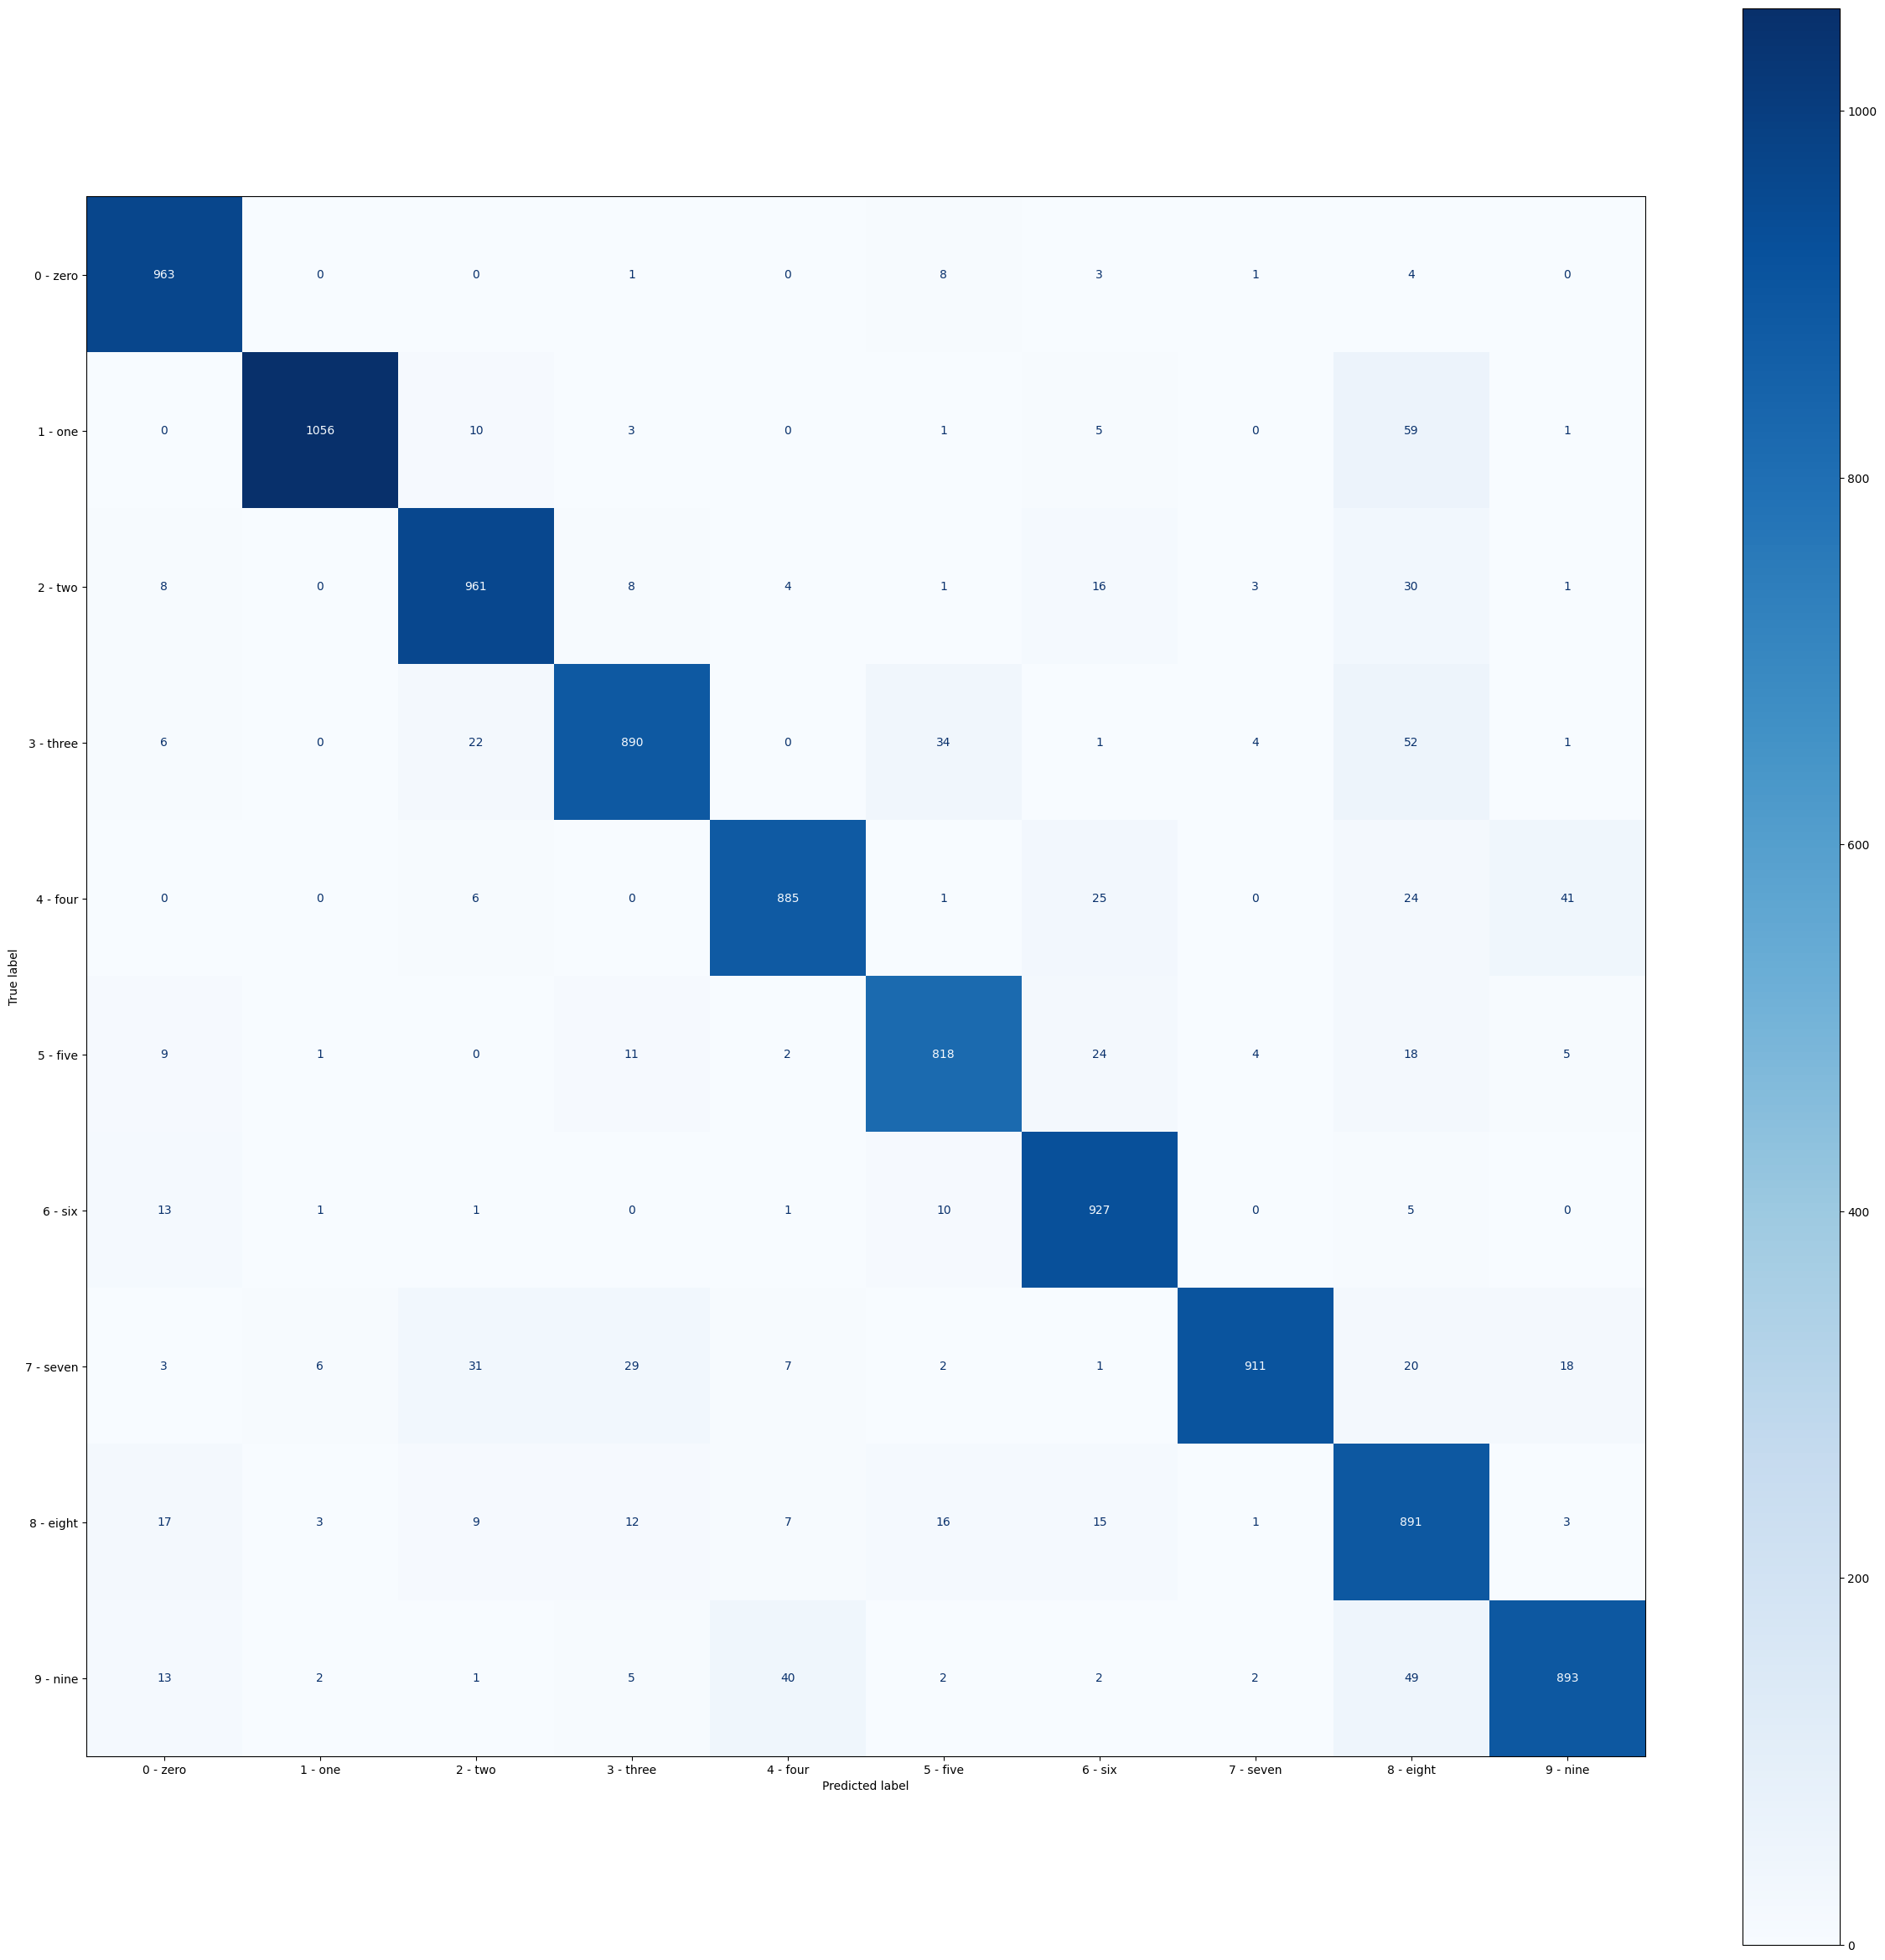

Test Loss: 0.298735

Test Accuracy of     0: 98% (963/980)
Test Accuracy of     1: 93% (1056/1135)
Test Accuracy of     2: 93% (961/1032)
Test Accuracy of     3: 88% (890/1010)
Test Accuracy of     4: 90% (885/982)
Test Accuracy of     5: 91% (818/892)
Test Accuracy of     6: 96% (927/958)
Test Accuracy of     7: 88% (911/1028)
Test Accuracy of     8: 91% (891/974)
Test Accuracy of     9: 88% (893/1009)


In [116]:
confusion_matrix_eval(model)

CNN

In [117]:
# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [118]:
model = CNN()
optimizer = optim.SGD(model.parameters(),lr=0.001)
path = '/mnt/d/VSCode/TD_Systèmes_Intelligents_Avancés/Results/CNN/'
if(check_file_exists(path)):
    clear_directory(path)
writer = SummaryWriter(log_dir=path) #Initializing Tensorboard to store logs in the specified directory
train_model(model,optimizer,writer,20)

Epoch: 1 	Training Loss: 2.282568 	Validation Loss: 2.256604 	Accuracy: 0.157083 	Validation Accuracy: 0.413750
Epoch: 2 	Training Loss: 2.232093 	Validation Loss: 2.198217 	Accuracy: 0.317437 	Validation Accuracy: 0.572083
Epoch: 3 	Training Loss: 2.157101 	Validation Loss: 2.098843 	Accuracy: 0.444812 	Validation Accuracy: 0.624167
Epoch: 4 	Training Loss: 2.028415 	Validation Loss: 1.925554 	Accuracy: 0.528479 	Validation Accuracy: 0.653833
Epoch: 5 	Training Loss: 1.813349 	Validation Loss: 1.634266 	Accuracy: 0.578812 	Validation Accuracy: 0.710250
Epoch: 6 	Training Loss: 1.508366 	Validation Loss: 1.270736 	Accuracy: 0.628625 	Validation Accuracy: 0.764667
Epoch: 7 	Training Loss: 1.206749 	Validation Loss: 0.967269 	Accuracy: 0.681583 	Validation Accuracy: 0.808333
Epoch: 8 	Training Loss: 0.983483 	Validation Loss: 0.767946 	Accuracy: 0.727729 	Validation Accuracy: 0.838667
Epoch: 9 	Training Loss: 0.840153 	Validation Loss: 0.646199 	Accuracy: 0.759667 	Validation Accuracy: 0

Confusion Matrix

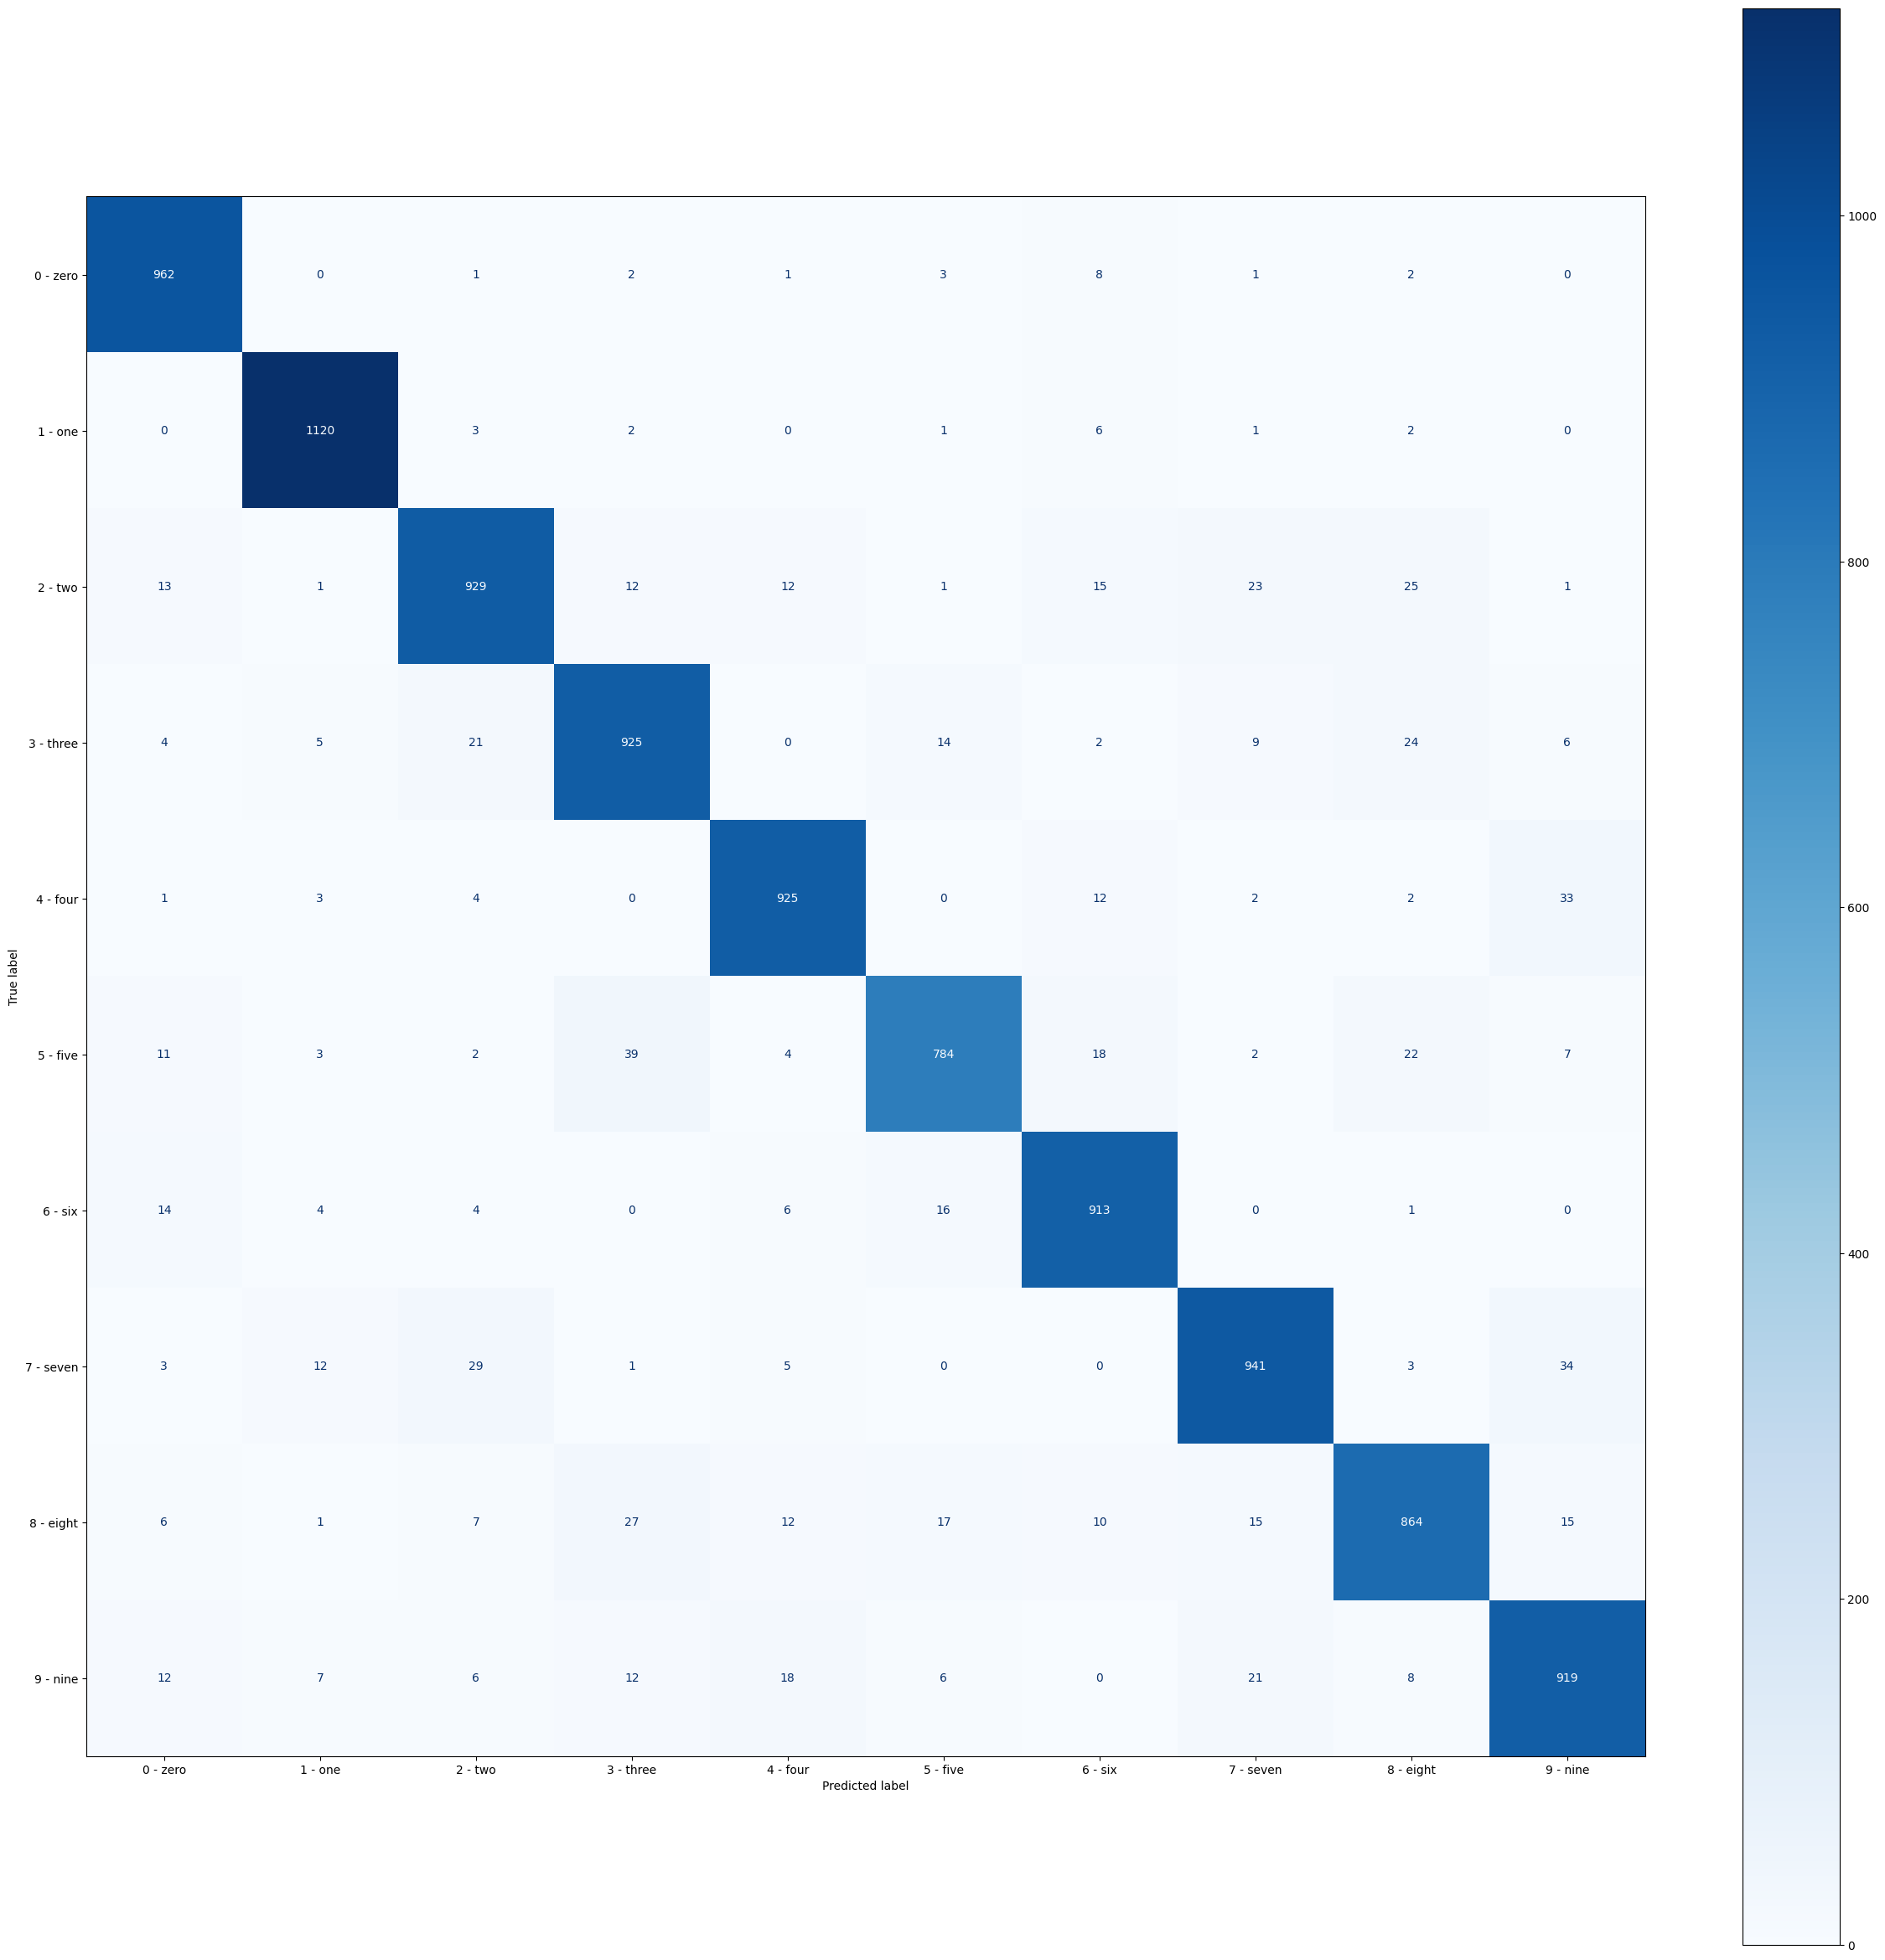

Test Loss: 0.267560

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 98% (1120/1135)
Test Accuracy of     2: 90% (929/1032)
Test Accuracy of     3: 91% (925/1010)
Test Accuracy of     4: 94% (925/982)
Test Accuracy of     5: 87% (784/892)
Test Accuracy of     6: 95% (913/958)
Test Accuracy of     7: 91% (941/1028)
Test Accuracy of     8: 88% (864/974)
Test Accuracy of     9: 91% (919/1009)


In [119]:
confusion_matrix_eval(model)